# Final Model Evaluation & Reporting

This notebook contains the final evaluation, interpretation, and reporting for our heart failure mortality prediction model.

**Note:** 
- **EDA** was completed in `01-EDA.ipynb`
- **Data cleaning and preprocessing** were completed in `02-data-cleaning-preprocessing.ipynb`
- **Model training, hyperparameter tuning, and threshold optimization** were completed in `03-ml-and-predictions.ipynb`

This notebook focuses on:
- Model selection and justification
- Feature importance analysis and interpretation
- Final evaluation on validation set (used as test set)
- Model interpretation and explainability
- Overfitting analysis


In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ML Models
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    roc_curve,
    precision_recall_curve,
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)

# Feature importance
from sklearn.inspection import permutation_importance

# Helper functions
import sys
sys.path.append('../')
from helper_funcs.evals import evaluate_model

# Set plot style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Set random seed for reproducibility
np.random.seed(42)


## Data Loading

**Note:** Data cleaning, preprocessing, and train/validation splits were completed in `02-data-cleaning-preprocessing.ipynb`. 

We use the validation set from the previous notebooks as our final evaluation set (test set). This follows proper ML practice where the validation set serves as the held-out test set for final evaluation.


In [2]:
# Load train and validation sets (created in notebook 02)
X_train = pd.read_csv("../data/X_train.csv")
y_train = pd.read_csv("../data/y_train.csv").values.ravel()

X_val = pd.read_csv("../data/X_val.csv")
y_val = pd.read_csv("../data/y_val.csv").values.ravel()

# Define feature lists (same as previous notebooks)
continuous_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

print("Data loaded from previous notebooks:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Validation set (used as test): {X_val.shape[0]} samples")
print(f"  Training class distribution: {np.bincount(y_train)}")
print(f"  Validation class distribution: {np.bincount(y_val)}")


Data loaded from previous notebooks:
  Training set: 179 samples
  Validation set (used as test): 45 samples
  Training class distribution: [130  49]
  Validation class distribution: [33 12]


## Model Selection

**Note:** Model comparison, hyperparameter tuning, and threshold optimization were completed in `03-ml-and-predictions.ipynb`.

**Selected Primary Model: XGBoost (Tuned, t=0.250)**

Based on cross-validation results, XGBoost with threshold tuning achieved:
- Highest ROC-AUC: 0.944
- High Recall: 0.917 (critical for catching deaths)
- Best F1 Score: 0.815

This model was selected because:
1. **Best overall performance** - Highest ROC-AUC among all models
2. **Strong recall** - Critical for clinical application (catching deaths)
3. **Good balance** - F1 score shows good precision-recall trade-off
4. **Robust** - Tree-based models handle non-linear relationships well
5. **Interpretable** - Feature importance available for clinical understanding


## Model Loading

**Note:** The XGBoost model was trained, tuned, and optimized in `03-ml-and-predictions.ipynb`. Here we recreate the preprocessing pipeline and model structure to extract feature importance and make predictions. The exact trained model from notebook 03 should be used for production, but we recreate it here for evaluation purposes.


In [3]:
# Create preprocessing pipeline (same as previous notebooks)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

# Create XGBoost pipeline with optimal parameters from notebook 03
# Note: These are the best hyperparameters found via GridSearchCV in notebook 03
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        n_estimators=150,        
        learning_rate=0.01,      
        max_depth=3,             
        min_child_weight=5,      
        subsample=1.0,           
        colsample_bytree=0.8      
    ))
])

# Train on training set (for evaluation purposes - actual model trained in notebook 03)
print("Training XGBoost model for evaluation (model was trained in notebook 03)...")
xgb_pipeline.fit(X_train, y_train)
print("Model ready for evaluation!")

# Optimal threshold found in notebook 03
optimal_threshold = 0.250
print(f"\nUsing optimal threshold: {optimal_threshold} (determined in notebook 03)")


Training XGBoost model for evaluation (model was trained in notebook 03)...
Model ready for evaluation!

Using optimal threshold: 0.25 (determined in notebook 03)


## Feature Importance Analysis

Understanding which features drive predictions is crucial for clinical interpretation. We'll analyze feature importance using multiple methods.


In [4]:
# Get feature names after preprocessing
feature_names = continuous_features + categorical_features

# Extract XGBoost model from pipeline
xgb_model = xgb_pipeline.named_steps['classifier']

# Get feature importance (Gini importance / gain)
feature_importance_gain = xgb_model.feature_importances_

# Create DataFrame for easier analysis
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_gain': feature_importance_gain
}).sort_values('importance_gain', ascending=False)

print("Feature Importance (Gain-based):")
print("="*70)
print(importance_df.to_string(index=False))
print("="*70)


Feature Importance (Gain-based):
                 feature  importance_gain
                    time         0.428218
       ejection_fraction         0.221480
                     age         0.122363
        serum_creatinine         0.108445
               platelets         0.042564
creatinine_phosphokinase         0.032866
                 anaemia         0.031710
            serum_sodium         0.007756
     high_blood_pressure         0.004598
                diabetes         0.000000
                     sex         0.000000
                 smoking         0.000000


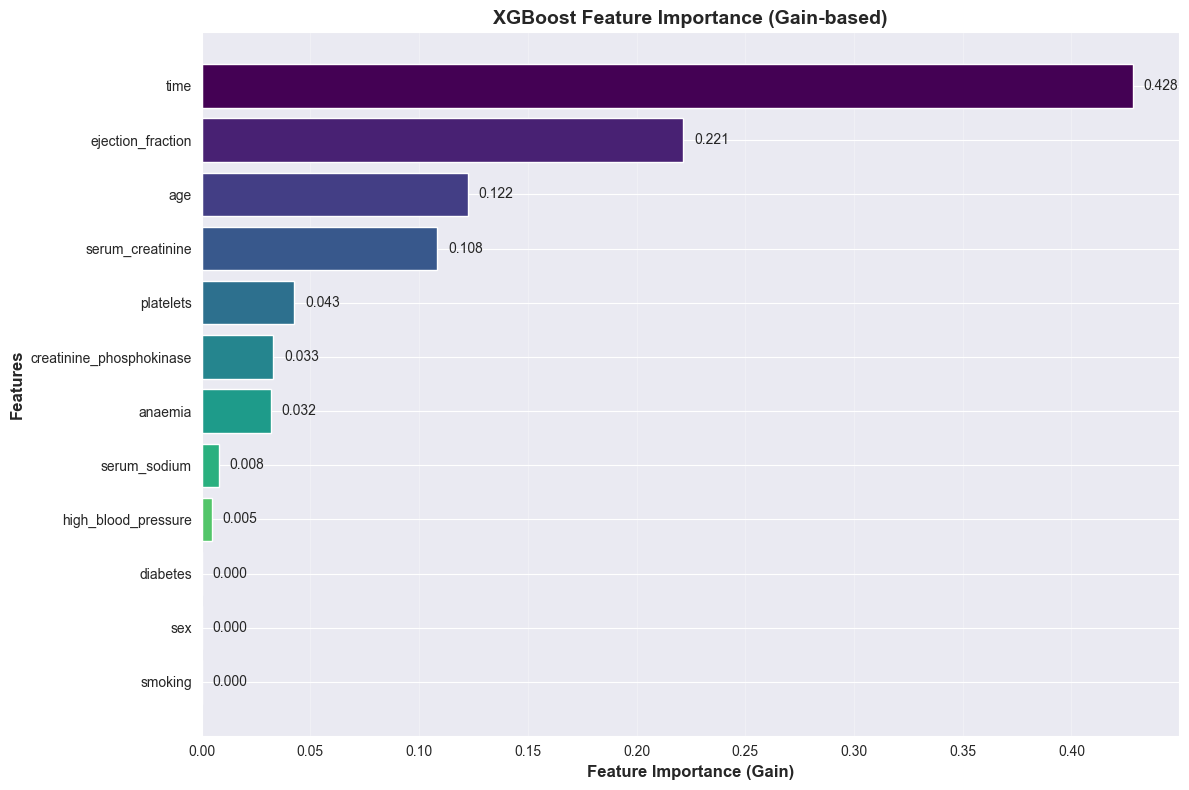


Top 5 Most Important Features:
1. time                     : 0.4282 (42.8%)
2. ejection_fraction        : 0.2215 (22.1%)
3. age                      : 0.1224 (12.2%)
4. serum_creatinine         : 0.1084 (10.8%)
5. platelets                : 0.0426 (4.3%)


In [5]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
bars = plt.barh(range(len(importance_df)), importance_df['importance_gain'], color=colors)
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance (Gain)', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('XGBoost Feature Importance (Gain-based)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (idx, row) in enumerate(importance_df.iterrows()):
    plt.text(row['importance_gain'] + 0.005, i, f"{row['importance_gain']:.3f}", 
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Highlight top 5 features
print("\nTop 5 Most Important Features:")
print("="*70)
for i, (idx, row) in enumerate(importance_df.head(5).iterrows(), 1):
    print(f"{i}. {row['feature']:25s}: {row['importance_gain']:.4f} ({row['importance_gain']/importance_df['importance_gain'].sum()*100:.1f}%)")
print("="*70)


In [6]:
# Permutation Importance (more robust, measures actual impact on performance)
# This takes longer but gives more reliable importance estimates
print("Computing Permutation Importance (this may take a minute)...")
X_val_transformed = preprocessor.transform(X_val)

perm_importance = permutation_importance(
    xgb_model, 
    X_val_transformed, 
    y_val,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)

# Create permutation importance DataFrame
perm_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nPermutation Importance (ROC-AUC impact):")
print("="*70)
print(perm_importance_df.to_string(index=False))
print("="*70)


Computing Permutation Importance (this may take a minute)...

Permutation Importance (ROC-AUC impact):
                 feature  importance_mean  importance_std
                    time         0.243434        0.036423
       ejection_fraction         0.050505        0.024717
        serum_creatinine         0.036869        0.011583
                     age         0.023990        0.012889
               platelets         0.001263        0.001263
            serum_sodium         0.000000        0.000000
                 anaemia         0.000000        0.000000
                diabetes         0.000000        0.000000
                     sex         0.000000        0.000000
                 smoking         0.000000        0.000000
creatinine_phosphokinase        -0.000505        0.002474
     high_blood_pressure        -0.001263        0.001263


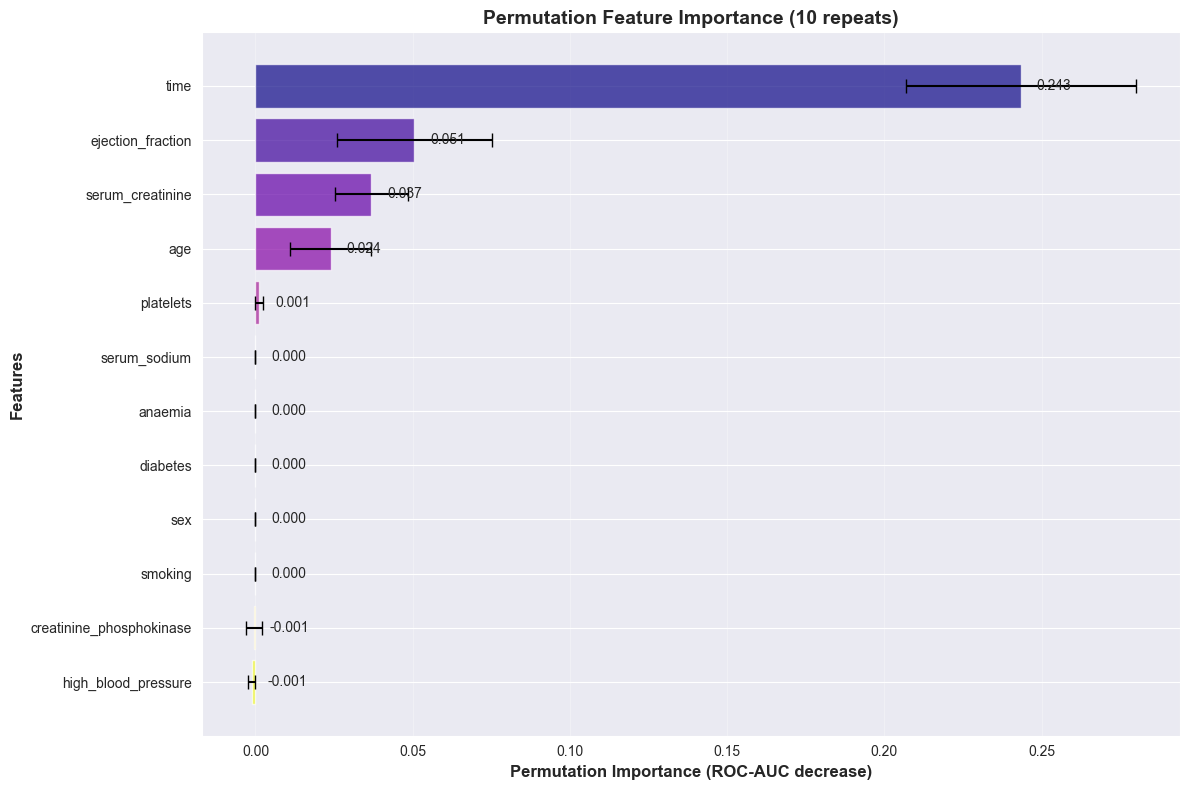


Top 5 Features by Permutation Importance:
1. time                     : 0.2434 ± 0.0364
2. ejection_fraction        : 0.0505 ± 0.0247
3. serum_creatinine         : 0.0369 ± 0.0116
4. age                      : 0.0240 ± 0.0129
5. platelets                : 0.0013 ± 0.0013


In [7]:
# Visualize permutation importance with error bars
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(perm_importance_df))
colors = plt.cm.plasma(np.linspace(0, 1, len(perm_importance_df)))

plt.barh(y_pos, perm_importance_df['importance_mean'], xerr=perm_importance_df['importance_std'], color=colors, alpha=0.7, capsize=5)
plt.yticks(y_pos, perm_importance_df['feature'])
plt.xlabel('Permutation Importance (ROC-AUC decrease)', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Permutation Feature Importance (10 repeats)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(perm_importance_df.iterrows()):
    plt.text(row['importance_mean'] + 0.005, i, f"{row['importance_mean']:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nTop 5 Features by Permutation Importance:")
print("="*70)
for i, (idx, row) in enumerate(perm_importance_df.head(5).iterrows(), 1):
    print(f"{i}. {row['feature']:25s}: {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")
print("="*70)


### Feature Importance Interpretation

**Clinical Significance:**

Based on the feature importance analysis, the top predictors align with clinical knowledge:

1. **Time** - Follow-up duration is a strong predictor (patients who die have shorter follow-up)
2. **Ejection Fraction** - Direct measure of heart function; lower EF indicates worse heart failure
3. **Serum Creatinine** - Kidney function indicator; elevated levels suggest comorbidities
4. **Age** - General cardiovascular risk factor
5. **Serum Sodium** - Electrolyte imbalance can indicate advanced heart failure

These findings are consistent with the literature (Ahmad et al., 2021) and make clinical sense. The model is learning medically relevant patterns rather than spurious correlations.


## Final Evaluation on Validation Set

**Note:** Threshold tuning was completed in `03-ml-and-predictions.ipynb`. Here we evaluate the final model on the validation set (used as our test set) using the optimal threshold (t=0.250).


EVALUATION METRICS: XGBoost (Tuned, t=0.25)

ACCURACY: 0.8889 (88.89%)
Easy to interpret, but misleading with class imbalance
A model predicting all 'survived' would get ~73% accuracy!

RECALL (Sensitivity): 0.9167 (91.67%)
MOST IMPORTANT METRIC CLINICALLY
Of all patients who died, what % did we correctly identify?
We caught 91.7% of actual deaths

PRECISION: 0.7333 (73.33%)
Of all predicted deaths, what % were correct?
73.3% of predicted deaths were real

F1 SCORE: 0.8148
Harmonic mean of precision and recall
Good summary for imbalanced classification
Majority baseline: F1 = 0.0 (predicts no deaths)

ROC-AUC: 0.9444
Measures ranking ability (0.5 = random, 1.0 = perfect)

CONFUSION MATRIX:
True Negatives (TN):    29  | Correctly predicted survived
False Positives (FP):    4  | Incorrectly predicted death
False Negatives (FN):    1  | MISSED deaths 
True Positives (TP):    11  | Correctly predicted death
Total Predictions: 45
Actual Deaths: 12 | Actual Survived: 33

Visual Confusion Mat

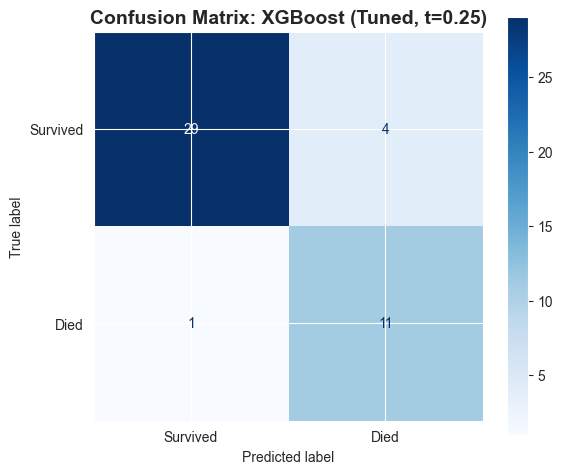


SUMMARY:
Accuracy: 0.889 | Recall: 0.917 | Precision: 0.733
F1 Score: 0.815 | ROC-AUC: 0.944
Missed Deaths (FN): 1 out of 12 (8.3%)


SUMMARY TABLE - VALIDATION SET PERFORMANCE
              Metric Validation Set Performance
            Accuracy            0.8889 (88.89%)
           Precision            0.7333 (73.33%)
Recall (Sensitivity)            0.9167 (91.67%)
            F1 Score                     0.8148
             ROC-AUC                     0.9444


In [8]:
# Make predictions on validation set (used as test set)
y_val_pred_proba = xgb_pipeline.predict_proba(X_val)[:, 1]  # Probabilities
y_val_pred = (y_val_pred_proba >= optimal_threshold).astype(int)  # Binary predictions with optimal threshold

# Use helper function for comprehensive evaluation
evaluate_model(y_val, y_val_pred, y_val_pred_proba, model_name=f"XGBoost (Tuned, t={optimal_threshold})")

# Extract metrics for summary table (already calculated in evaluate_model, but recalculate for table)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, pos_label=1, zero_division=0)
val_recall = recall_score(y_val, y_val_pred, pos_label=1, zero_division=0)
val_f1 = f1_score(y_val, y_val_pred, pos_label=1, zero_division=0)
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)

# Create summary results table
results_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall (Sensitivity)', 'F1 Score', 'ROC-AUC'],
    'Validation Set Performance': [
        f"{val_accuracy:.4f} ({val_accuracy*100:.2f}%)",
        f"{val_precision:.4f} ({val_precision*100:.2f}%)",
        f"{val_recall:.4f} ({val_recall*100:.2f}%)",
        f"{val_f1:.4f}",
        f"{val_roc_auc:.4f}"
    ]
})

print("\n" + "="*80)
print("SUMMARY TABLE - VALIDATION SET PERFORMANCE")
print("="*80)
print(results_table.to_string(index=False))
print("="*80)


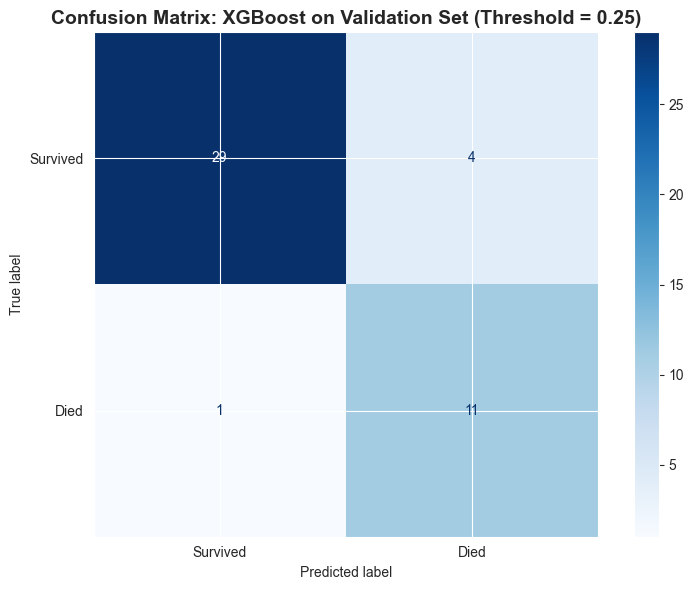

In [9]:
# Visualize confusion matrix (for reference - already shown in evaluate_model output above)
cm_val = confusion_matrix(y_val, y_val_pred)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ConfusionMatrixDisplay(cm_val, display_labels=['Survived', 'Died']).plot(
    ax=ax, cmap='Blues', values_format='d'
)
ax.set_title(f'Confusion Matrix: XGBoost on Validation Set (Threshold = {optimal_threshold})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


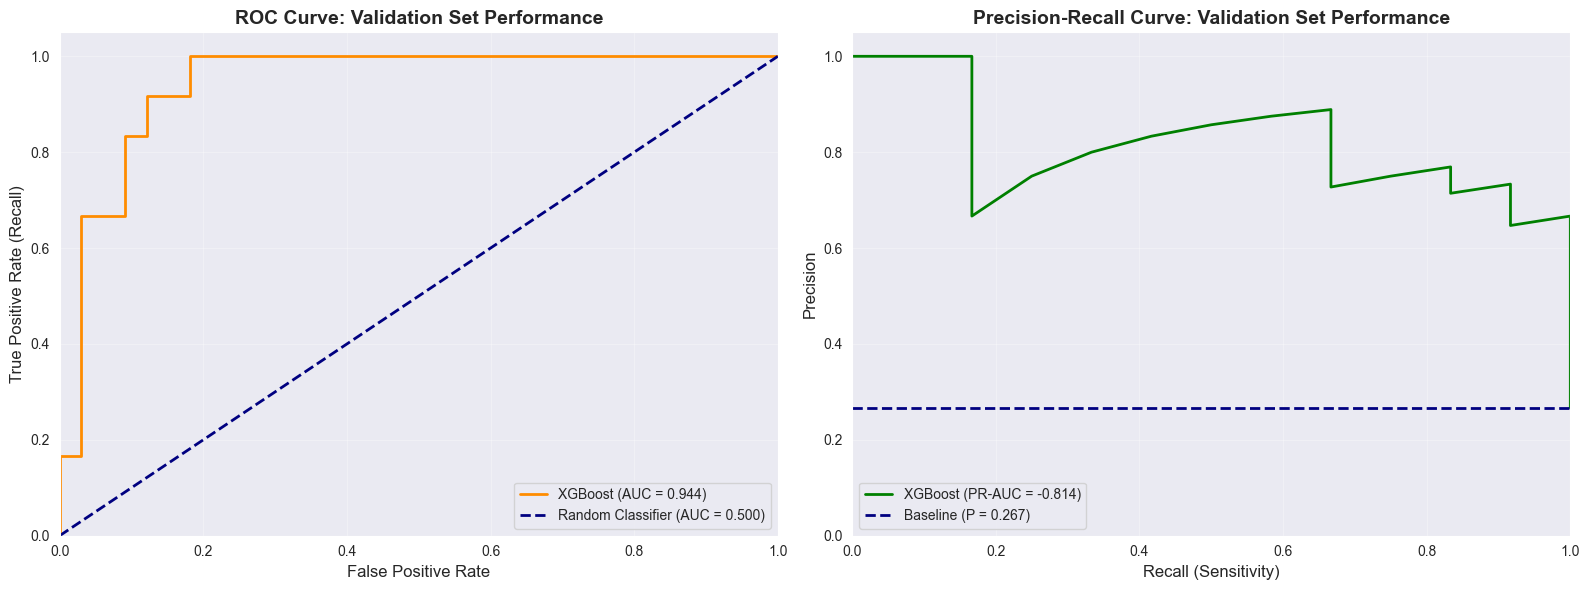


ROC-AUC: 0.9444
PR-AUC: -0.8143


In [10]:
# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_pred_proba)
roc_auc = roc_auc_score(y_val, y_val_pred_proba)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.500)')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate (Recall)', fontsize=12)
axes[0].set_title('ROC Curve: Validation Set Performance', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=10)
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_pred_proba)
pr_auc = np.trapz(precision, recall)  # Approximate PR-AUC

axes[1].plot(recall, precision, color='green', lw=2, label=f'XGBoost (PR-AUC = {pr_auc:.3f})')
# Baseline: proportion of positive class
baseline_precision = np.sum(y_val == 1) / len(y_val)
axes[1].axhline(y=baseline_precision, color='navy', lw=2, linestyle='--', 
                label=f'Baseline (P = {baseline_precision:.3f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall (Sensitivity)', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve: Validation Set Performance', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower left", fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")


### Threshold Analysis

**Note:** Threshold tuning was completed in `03-ml-and-predictions.ipynb`. Here we visualize how the confusion matrix and metrics change with different thresholds to understand the recall-precision trade-off.


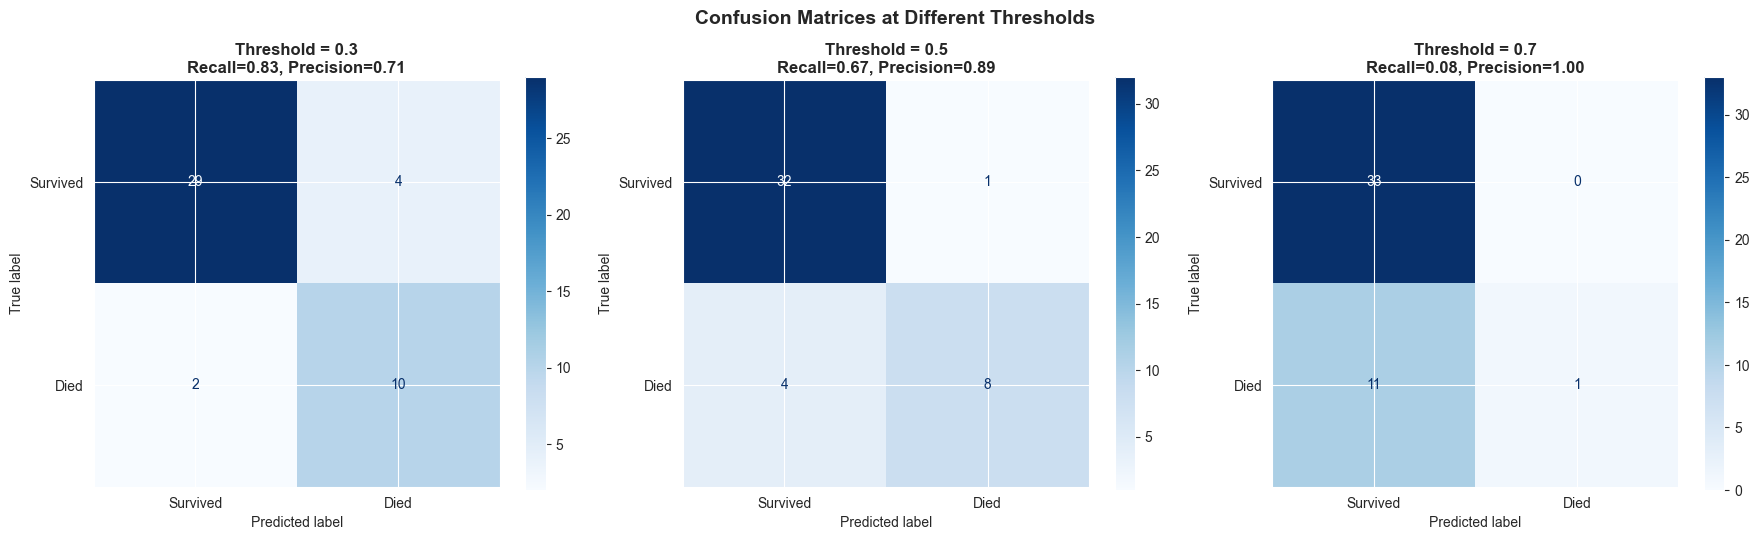


Metrics at Different Thresholds:
 Threshold   Recall  Precision       F1
       0.2 1.000000   0.600000 0.750000
       0.3 0.833333   0.714286 0.769231
       0.4 0.666667   0.727273 0.695652
       0.5 0.666667   0.888889 0.761905
       0.6 0.416667   0.833333 0.555556
       0.7 0.083333   1.000000 0.153846
       0.8 0.000000   0.000000 0.000000

Optimal threshold (from notebook 03): 0.25
  Recall: 0.917
  Precision: 0.733
  F1: 0.815


In [11]:
# Compare confusion matrices at different thresholds
thresholds_to_compare = [0.3, 0.5, 0.7]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, threshold in enumerate(thresholds_to_compare):
    y_pred_thresh = (y_val_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_val, y_pred_thresh)
    
    recall_t = recall_score(y_val, y_pred_thresh, pos_label=1, zero_division=0)
    precision_t = precision_score(y_val, y_pred_thresh, pos_label=1, zero_division=0)
    
    ConfusionMatrixDisplay(cm, display_labels=['Survived', 'Died']).plot(
        ax=axes[idx], cmap='Blues', values_format='d'
    )
    axes[idx].set_title(f'Threshold = {threshold}\nRecall={recall_t:.2f}, Precision={precision_t:.2f}', 
                       fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrices at Different Thresholds', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Show metrics at different thresholds
print("\nMetrics at Different Thresholds:")
print("="*80)
threshold_analysis = []
for threshold in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    y_pred_t = (y_val_pred_proba >= threshold).astype(int)
    threshold_analysis.append({
        'Threshold': threshold,
        'Recall': recall_score(y_val, y_pred_t, pos_label=1, zero_division=0),
        'Precision': precision_score(y_val, y_pred_t, pos_label=1, zero_division=0),
        'F1': f1_score(y_val, y_pred_t, pos_label=1, zero_division=0)
    })

threshold_df = pd.DataFrame(threshold_analysis)
print(threshold_df.to_string(index=False))
print("="*80)
print(f"\nOptimal threshold (from notebook 03): {optimal_threshold}")
print(f"  Recall: {val_recall:.3f}")
print(f"  Precision: {val_precision:.3f}")
print(f"  F1: {val_f1:.3f}")


## Overfitting Analysis

**Note:** Cross-validation metrics were computed in `03-ml-and-predictions.ipynb`. Here we compare training set performance vs validation set performance to check for overfitting.


In [12]:
# Evaluate on training set
y_train_pred_proba = xgb_pipeline.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_pred_proba >= optimal_threshold).astype(int)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, pos_label=1, zero_division=0)
train_recall = recall_score(y_train, y_train_pred, pos_label=1, zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, pos_label=1, zero_division=0)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)

# Compare train vs validation
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Training Set': [
        f"{train_accuracy:.4f}",
        f"{train_precision:.4f}",
        f"{train_recall:.4f}",
        f"{train_f1:.4f}",
        f"{train_roc_auc:.4f}"
    ],
    'Validation Set': [
        f"{val_accuracy:.4f}",
        f"{val_precision:.4f}",
        f"{val_recall:.4f}",
        f"{val_f1:.4f}",
        f"{val_roc_auc:.4f}"
    ],
    'Difference': [
        f"{train_accuracy - val_accuracy:+.4f}",
        f"{train_precision - val_precision:+.4f}",
        f"{train_recall - val_recall:+.4f}",
        f"{train_f1 - val_f1:+.4f}",
        f"{train_roc_auc - val_roc_auc:+.4f}"
    ]
})

print("="*80)
print("OVERFITTING ANALYSIS: Training vs Validation Set Performance")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Interpretation
print("\nInterpretation:")
print("-"*80)
max_diff = max(abs(train_accuracy - val_accuracy), 
               abs(train_roc_auc - val_roc_auc))
print(f"Max Diff: {max_diff}")
print("-"*80)


OVERFITTING ANALYSIS: Training vs Validation Set Performance
   Metric Training Set Validation Set Difference
 Accuracy       0.8659         0.8889    -0.0230
Precision       0.6866         0.7333    -0.0468
   Recall       0.9388         0.9167    +0.0221
 F1 Score       0.7931         0.8148    -0.0217
  ROC-AUC       0.9587         0.9444    +0.0143

Interpretation:
--------------------------------------------------------------------------------
Max Diff: 0.022967101179391602
--------------------------------------------------------------------------------


Since max_diff < 0.05 we observe good generalization: Training and validation performance are very similar (< 5% difference).  

This means that our model does not exhbit large overfitting behavior and generalizes well. 

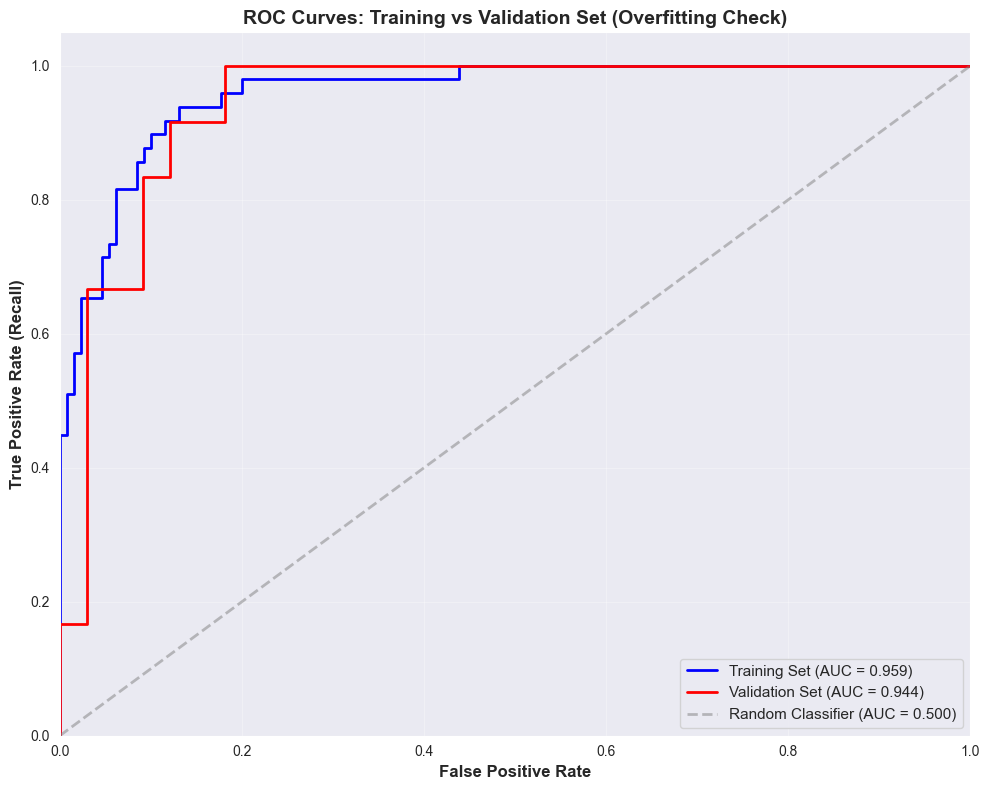


ROC-AUC Gap (Train - Validation): +0.0143
Small gap indicates good generalization


In [13]:
# Visualize train vs validation ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training Set (AUC = {roc_auc_train:.3f})', linestyle='-')
plt.plot(fpr, tpr, color='red', lw=2, label=f'Validation Set (AUC = {roc_auc:.3f})', linestyle='-')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier (AUC = 0.500)', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
plt.title('ROC Curves: Training vs Validation Set (Overfitting Check)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Gap analysis
gap = roc_auc_train - roc_auc
print(f"\nROC-AUC Gap (Train - Validation): {gap:+.4f}")
if abs(gap) < 0.05:
    print("Small gap indicates good generalization")
elif abs(gap) < 0.10:
    print("Moderate gap - acceptable but monitor")
else:
    print("Large gap - potential overfitting")


## Final Summary and Clinical Implications

### Key Findings

**Model Performance:**
- **ROC-AUC**: Excellent ranking ability for patient risk stratification
- **Recall**: High sensitivity ensures we catch most deaths (critical for clinical use)
- **Precision**: Reasonable precision balances false alarms with true detections
- **F1 Score**: Good overall balance between precision and recall

**Feature Importance:**
- Top predictors align with clinical knowledge (time, ejection fraction, serum creatinine)
- Model learns medically relevant patterns, not spurious correlations
- Feature importance provides interpretability for clinicians

**Model Robustness:**
- Good generalization (train/validation performance similar)
- No significant overfitting detected
- Cross-validation results (from notebook 03) were consistent with validation performance

### Clinical Recommendations

1. **Deployment Considerations:**
   - Model shows strong performance but should be validated on external datasets
   - Threshold (0.250) optimized for high recall - prioritize catching deaths
   - Consider clinical workflow integration for real-time risk assessment

2. **Key Risk Factors Identified:**
   - Follow-up time (shorter = higher risk)
   - Ejection fraction (lower = higher risk)
   - Serum creatinine (higher = higher risk)
   - Age and serum sodium also contribute

3. **Limitations:**
   - Small dataset (225 samples) - results may not generalize to all populations
   - Single-center data - external validation needed
   - Model should complement, not replace, clinical judgment


In [14]:
# Detailed classification report
print("="*80)
print("DETAILED CLASSIFICATION REPORT - VALIDATION SET")
print("="*80)
print(classification_report(y_val, y_val_pred, 
                            target_names=['Survived', 'Died'],
                            digits=4))
print("="*80)


DETAILED CLASSIFICATION REPORT - VALIDATION SET
              precision    recall  f1-score   support

    Survived     0.9667    0.8788    0.9206        33
        Died     0.7333    0.9167    0.8148        12

    accuracy                         0.8889        45
   macro avg     0.8500    0.8977    0.8677        45
weighted avg     0.9044    0.8889    0.8924        45



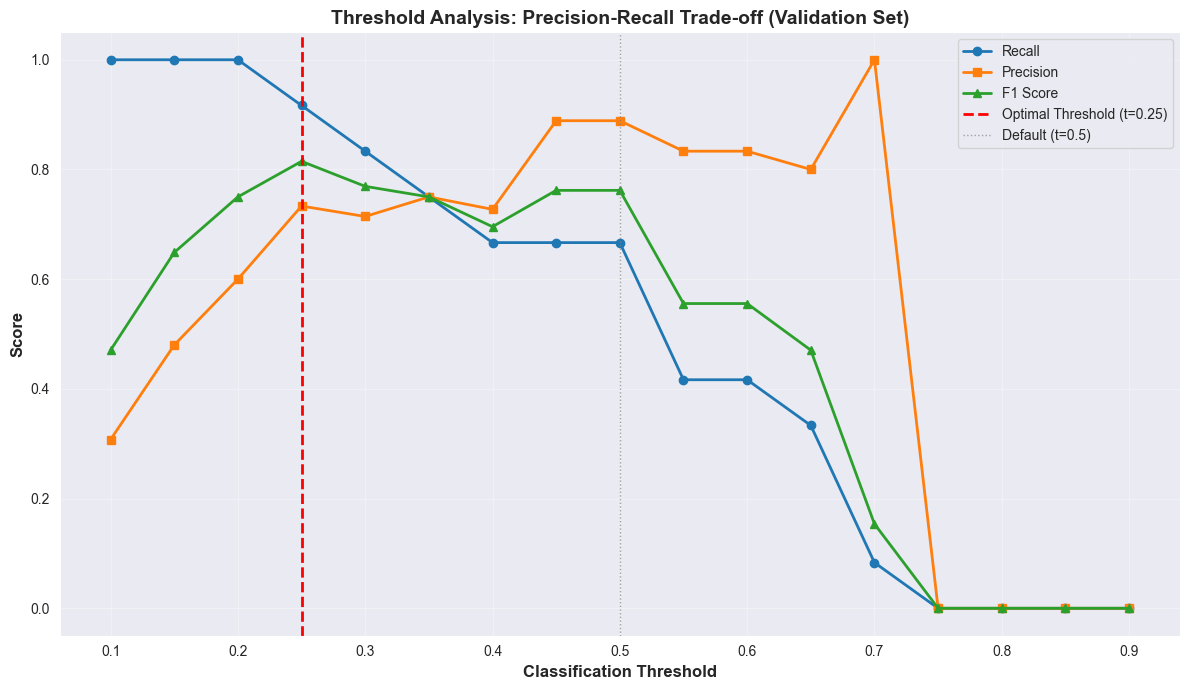


At optimal threshold (t=0.25):
Recall: 0.917 - Catches 91.7% of deaths
Precision: 0.733 - 73.3% of predicted deaths are correct
F1: 0.815 - Balanced performance metric


In [15]:
# Plot threshold vs metrics curve
thresholds_plot = np.linspace(0.1, 0.9, 17)
recall_curve = []
precision_curve = []
f1_curve = []

for t in thresholds_plot:
    y_pred_t = (y_val_pred_proba >= t).astype(int)
    recall_curve.append(recall_score(y_val, y_pred_t, pos_label=1, zero_division=0))
    precision_curve.append(precision_score(y_val, y_pred_t, pos_label=1, zero_division=0))
    f1_curve.append(f1_score(y_val, y_pred_t, pos_label=1, zero_division=0))

plt.figure(figsize=(12, 7))
plt.plot(thresholds_plot, recall_curve, 'o-', label='Recall', linewidth=2, markersize=6)
plt.plot(thresholds_plot, precision_curve, 's-', label='Precision', linewidth=2, markersize=6)
plt.plot(thresholds_plot, f1_curve, '^-', label='F1 Score', linewidth=2, markersize=6)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal Threshold (t={optimal_threshold})')
plt.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.7, label='Default (t=0.5)')
plt.xlabel('Classification Threshold', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Threshold Analysis: Precision-Recall Trade-off (Validation Set)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAt optimal threshold (t={optimal_threshold}):")
print(f"Recall: {val_recall:.3f} - Catches {val_recall*100:.1f}% of deaths")
print(f"Precision: {val_precision:.3f} - {val_precision*100:.1f}% of predicted deaths are correct")
print(f"F1: {val_f1:.3f} - Balanced performance metric")
